<a href="https://colab.research.google.com/github/MariaEspFon/Scripts-propios/blob/main/TensorFlow/CNN_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# MODELO 1: red neuronal convolucional (CNN)

## 1. Inicialización de Keras y TensorFlow

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("TensorFlow version: ", tf.__version__)

from tensorflow import keras
#print("Keras version: ", tf.keras.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%reload_ext tensorboard

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
TensorFlow version:  2.18.0


## 2. Carga de datos EDA desde Github

In [2]:
url = 'https://raw.githubusercontent.com/MariaEspFon/Scripts-propios/main/MATLAB/EDA_data.csv'
column_names = ['Mean', 'Median', 'Standard Dev', 'Max Value', 'Min Value', 'Standard Dev 1st diff', 'Median 1st diff', 'Standard Dev 2nd diff', 'Total Area', 'Kurtosis', 'Power', 'Low Bandwidth', 'High Bandwidth', 'State' ]
raw_dataset = pd.read_csv(url, names=column_names, sep=',', skipinitialspace=True)

size = raw_dataset.shape
print(f'Formato del dataset: {size}')

Formato del dataset: (4471, 14)


In [ ]:
raw_dataset.tail() # muestra las últimas 5 filas por defecto

In [ ]:
raw_dataset.head() # muestra las primeras 5 filas por defecto

## 3. Preprocesamiento de datos

### 3.1. Extracción de los conjuntos de entrenamiento, prueba y validación

*   Datos de **entrenamiento**: para el aprendizaje de parámetros.
*   Datos de **prueba**: para hacer test de predicciones.
*   Datos de **validación**: para afinar hiperparámetros.



In [3]:
train_dataset = raw_dataset.sample(frac=0.8,random_state=0)
# random_state=0 marca la semilla aleatoria para escoger muestras
test_dataset = raw_dataset.drop(train_dataset.index)
# drop coge el resto de datos desde la posición final de train_dataset

In [5]:
train_labels = train_dataset.pop('State')
test_labels = test_dataset.pop('State')
#del train_dataset['Number of SCR']
#del test_dataset['Number of SCR']

KeyError: 'State'

In [6]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Mean,3577.0,1.363897,2.542184,2.881417e-04,0.237573,0.413689,1.002394,16.907668
Median,3577.0,1.369230,2.557778,2.351932e-22,0.237412,0.416184,0.987953,17.070575
Standard Dev,3577.0,0.141251,0.345816,7.476786e-04,0.006451,0.030620,0.116392,5.383384
Max Value,3577.0,1.622600,2.811966,6.211061e-03,0.297770,0.492833,1.346439,20.546044
Min Value,3577.0,1.068527,2.316840,-2.450087e-01,0.072111,0.279829,0.618816,16.056648
Standard Dev 1st diff,3577.0,0.032563,0.057137,4.908710e-04,0.002001,0.008695,0.036407,1.132397
Median 1st diff,3577.0,-0.000706,0.003271,-5.691210e-02,-0.000499,-0.000083,0.000077,0.050073
Standard Dev 2nd diff,3577.0,0.027692,0.046817,4.823948e-04,0.002037,0.007695,0.032912,0.928403
Total Area,3577.0,162.308289,302.559923,3.457700e-02,28.259939,49.243425,119.233737,2020.010062
Kurtosis,3577.0,6.319672,8.071276,1.025025e+00,2.198263,3.148629,6.822772,113.719904


### 3.2. Normalización y estandarización de todos los datos

In [7]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)
train_size = normed_train_data.shape
test_size = normed_test_data.shape
print(f'Formato del dataset de training: {train_size}')
print(f'Formato del dataset de test: {test_size}')

Formato del dataset de training: (3577, 13)
Formato del dataset de test: (894, 13)


In [8]:
normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()
normed_train_stats

,count,mean,std,min,25%,50%,75%,max
Mean,3577.0,-1.787779e-17,1.0,-0.536393,-0.443054,-0.373776,-0.142202,6.114337
Median,3577.0,-4.022502e-17,1.0,-0.535320,-0.442500,-0.372607,-0.149066,6.138665
Standard Dev,3577.0,-2.880310e-17,1.0,-0.406295,-0.389804,-0.319914,-0.071886,15.158732
Max Value,3577.0,2.383705e-17,1.0,-0.574825,-0.471140,-0.401771,-0.098209,6.729612
Min Value,3577.0,9.932104e-19,1.0,-0.566951,-0.430075,-0.340420,-0.194105,6.469209
Standard Dev 1st diff,3577.0,-9.932104e-19,1.0,-0.561324,-0.534890,-0.417730,0.067279,19.249088
Median 1st diff,3577.0,-2.185063e-17,1.0,-17.180523,0.063174,0.190586,0.239417,15.521754
Standard Dev 2nd diff,3577.0,-4.370126e-17,1.0,-0.581182,-0.547981,-0.427124,0.111504,19.239014
Total Area,3577.0,-3.277594e-17,1.0,-0.536336,-0.443047,-0.373694,-0.142367,6.139947
Kurtosis,3577.0,1.191853e-17,1.0,-0.655986,-0.510627,-0.392880,0.062332,13.306474


## 4. Creación del modelo CNN

El primer modelo cuenta con 2 tipos de capas:
*     Capas convolucionales con un número variable de filtros de (2x1) o (3x1).
*     Capas densas en la salida para integrar toda la información convolucional y hacer la clasificación binaria (para la cual sólo es necesaria una neurona y una función sigmoid de activación).

Además, se incluye una capa accesoria para preparar los datos antes de la capa de salida (capa Flatten)

In [9]:
from keras import Sequential, layers, activations

def build_model_best(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', activation='relu', input_shape=(size[1],1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
   # compilación del modeo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

def build_model_ELU(size):
  model = Sequential()
  model.add(layers.Conv1D(27, 2, strides=1, padding='same', input_shape=(size[1],1)))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(22, 3, padding='valid'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(18, 4, padding='valid'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv1D(9, 4, padding='same'))
  model.add(layers.ELU(alpha=1.0))
  model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  model.add(layers.Dense(22, activation='relu'))
  model.add(layers.Dense(1, activation='sigmoid'))
  # compilación del modeo
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['binary_accuracy','precision','recall',keras.metrics.F1Score()])
  return model

model = build_model_ELU(train_size)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 13, 27)              │              81 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu (ELU)                            │ (None, 13, 27)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 13, 27)              │             108 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 11, 22)              │           1,804 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_1 (ELU)                          │ (None, 11, 22)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 22)              │              88 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 8, 18)               │           1,602 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_2 (ELU)                          │ (None, 8, 18)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 8, 18)               │              72 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 8, 9)                │             657 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ elu_3 (ELU)                          │ (None, 8, 9)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8, 9)                │              36 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 72)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 22)                  │           1,606 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              23 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,077 (23.74 KB)

 Trainable params: 5,925 (23.14 KB)

 Non-trainable params: 152 (608.00 B)

## 5. Entrenamiento del modelo

Reservamos el 20% de los datos de entrenamiento para la validación del modelo

In [10]:
EPOCHS = 700
history = model.fit(normed_train_data, train_labels, batch_size=511,
                    epochs=EPOCHS, validation_split = 0.2, verbose=0)
#1min 56s

In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,binary_accuracy,f1_score,loss,precision,recall,val_binary_accuracy,val_f1_score,val_loss,val_precision,val_recall,epoch
695,0.767564,0.762173,0.456910,0.771825,0.883589,0.653631,0.748252,0.761402,0.691489,0.759346,695
696,0.774205,0.762173,0.448509,0.788114,0.865985,0.657821,0.748252,0.768278,0.684848,0.792056,696
697,0.774904,0.762173,0.450744,0.789228,0.865417,0.659218,0.748252,0.765645,0.679688,0.813084,697
698,0.770010,0.762173,0.451334,0.768109,0.897218,0.652235,0.748252,0.759536,0.710588,0.705607,698
699,0.768263,0.762173,0.454665,0.781538,0.865417,0.662011,0.748252,0.770475,0.682353,0.813084,699


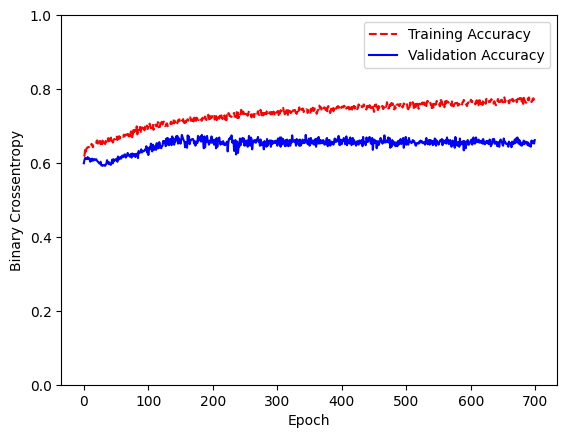

In [12]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Binary Crossentropy')
  plt.plot(hist['epoch'], hist['binary_accuracy'],'r--',
           label='Training Accuracy')
  plt.plot(hist['epoch'], hist['val_binary_accuracy'],'b',
           label = 'Validation Accuracy')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)

## 6. Validación del modelo con los datos de test


In [13]:
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(normed_test_data, test_labels, batch_size=(test_size[0]))
print(f'Test accuracy: {100*test_acc:.2f}%')
print(f'Test loss: {test_loss:.3f}')
# TensorFlow imprime las métricas en orden alfabético por defecto en la consola,
# pero el método evaluate() devuelve los valores en el mismo orden en que fueron definidos en model.compile().

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - binary_accuracy: 0.6857 - f1_score: 0.7623 - loss: 0.7025 - precision: 0.7079 - recall: 0.8327   
Test accuracy: 68.57%
Test loss: 0.703


28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step


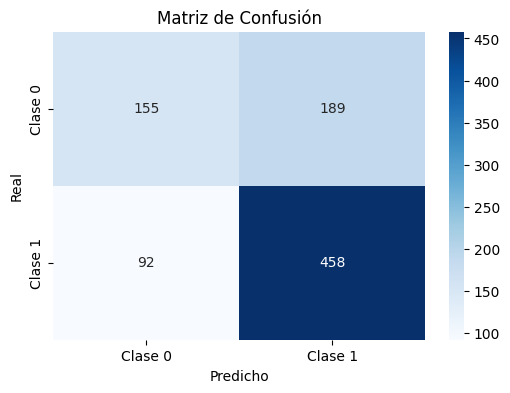

Reporte de clasificación:
              precision    recall  f1-score   support

     Clase 0       0.63      0.45      0.52       344
     Clase 1       0.71      0.83      0.77       550

    accuracy                           0.69       894
   macro avg       0.67      0.64      0.64       894
weighted avg       0.68      0.69      0.67       894



In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

predictions = model.predict(normed_test_data)
predicted_labels = (predictions > 0.5).astype(int)
cm = confusion_matrix(test_labels, predicted_labels)

# Muestra la matriz de confusión
def plot_confusion_matrix(cm):
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Clase 0', 'Clase 1'], yticklabels=['Clase 0', 'Clase 1'])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title('Matriz de Confusión')
    plt.show()

plot_confusion_matrix(cm)

# Muestra métricas adicionales
print("Reporte de clasificación:")
print(classification_report(test_labels, predicted_labels, target_names=['Clase 0', 'Clase 1']))
